In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Resize, Normalize
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from PIL import Image
from torchvision.transforms import RandomHorizontalFlip
from sklearn.metrics import accuracy_score
import copy
import cv2
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-train with pRCC Dataset

In [ ]:
camelyon16_path = '/content/drive/MyDrive/CAM16_100cls_10mask.zip'
prcc_path = '/content/drive/MyDrive/pRCC_nolabel.zip'

with zipfile.ZipFile(camelyon16_path, 'r') as zip_ref:
    camelyon16_extract_path = 'CAM16_100cls_10mask'
    zip_ref.extractall(camelyon16_extract_path)

with zipfile.ZipFile(prcc_path, 'r') as zip_ref:
    prcc_extract_path = 'pRCC_nolabel'
    zip_ref.extractall(prcc_extract_path)

camelyon16_dirs = os.listdir(camelyon16_extract_path)
prcc_dirs = os.listdir(prcc_extract_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class pRCCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

prcc_dataset = pRCCDataset(root_dir=os.path.join('pRCC_nolabel'), transform=transform)
prcc_loader = DataLoader(prcc_dataset, batch_size=4, shuffle=True)

# Check
images = next(iter(prcc_loader))
print(images.shape)
print(len(prcc_dataset))

torch.Size([4, 3, 128, 128])
1419


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 7

In [ ]:
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_images in prcc_loader:
        outputs = autoencoder(batch_images)
        loss = criterion(outputs, batch_images)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(prcc_loader)
    loss_values.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

print("Training completed!")

Epoch [1/7], Loss: 0.0295
Epoch [2/7], Loss: 0.0168
Epoch [3/7], Loss: 0.0133
Epoch [4/7], Loss: 0.0116
Epoch [5/7], Loss: 0.0106
Epoch [6/7], Loss: 0.0098
Epoch [7/7], Loss: 0.0092
Training completed!


In [ ]:
autoencoder_weights = copy.deepcopy(autoencoder.encoder.state_dict())

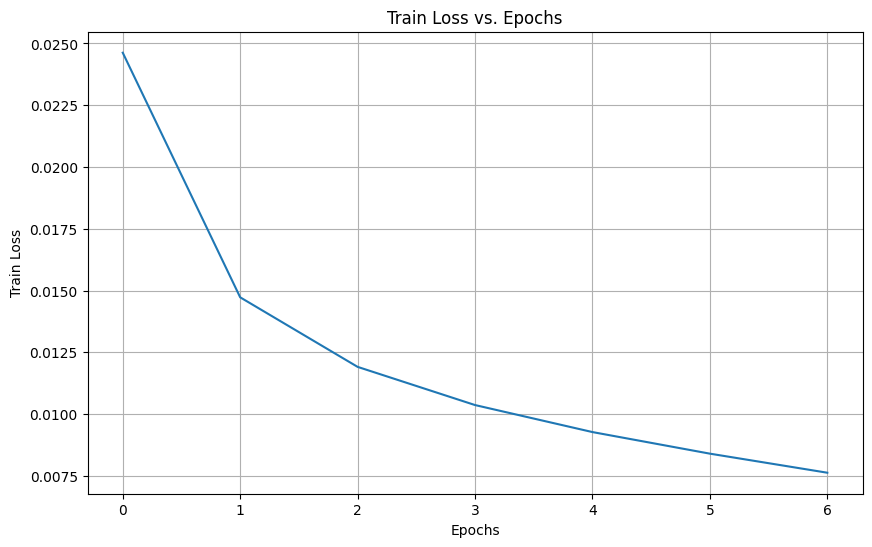

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title("Train Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.grid(True)
plt.show()

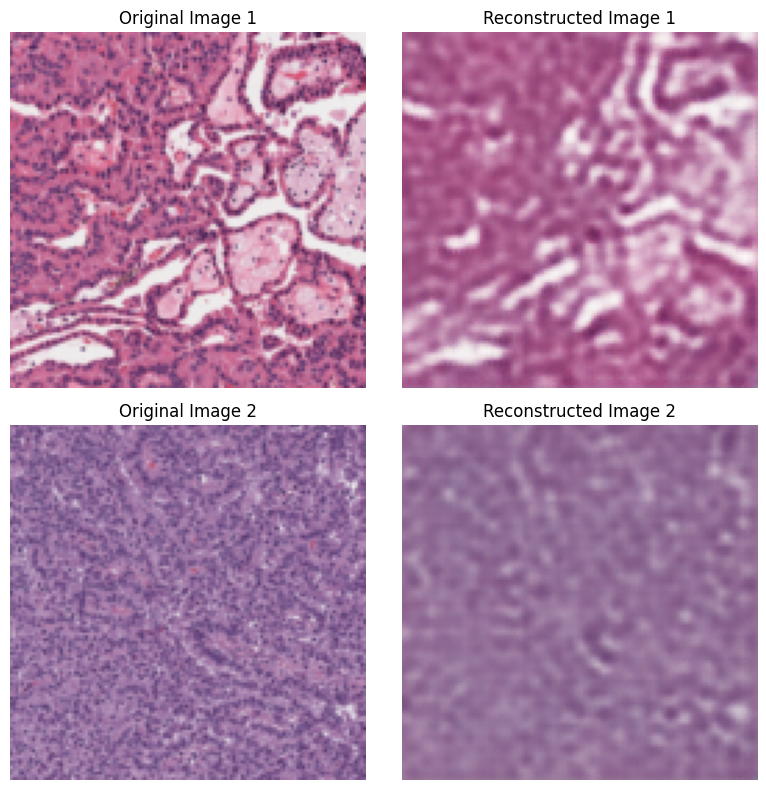

In [ ]:
sample_images = [prcc_dataset[i] for i in range(2)]

# Pass them through the trained autoencoder
with torch.no_grad():
    reconstructed_images = autoencoder(torch.stack(sample_images))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(sample_images[0].permute(1, 2, 0))
axes[0].set_title("Original Image 1")
axes[1].imshow(reconstructed_images[0].permute(1, 2, 0))
axes[1].set_title("Reconstructed Image 1")

axes[2].imshow(sample_images[1].permute(1, 2, 0))
axes[2].set_title("Original Image 2")
axes[3].imshow(reconstructed_images[1].permute(1, 2, 0))
axes[3].set_title("Reconstructed Image 2")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Supervised Pre-training on Camelyon16:

In [ ]:
class Camelyon16Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.normal_images = glob.glob(os.path.join(root_dir, 'data', 'normal', '*.jpg'))
        self.tumor_images = glob.glob(os.path.join(root_dir, 'data', 'tumor', '*.jpg'))
        self.all_images = self.normal_images + self.tumor_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        img = Image.open(img_path).convert('RGB')

        if 'normal' in img_path:
            label = 0
        else:
            label = 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
camelyon_transform = transforms.Compose([
    RandomHorizontalFlip(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = Camelyon16Dataset(root_dir='CAM16_100cls_10mask/train', transform=camelyon_transform)
val_dataset = Camelyon16Dataset(root_dir='CAM16_100cls_10mask/val', transform=camelyon_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

757
108


In [ ]:
class Camelyon16CNN(nn.Module):
    def __init__(self):
        super(Camelyon16CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return torch.sigmoid(x)

In [ ]:
camelyon16_cnn = Camelyon16CNN()
criterion_cnn = nn.BCELoss()
optimizer_cnn = torch.optim.Adam(camelyon16_cnn.parameters(), lr=0.001, weight_decay=1e-5)
train_losses = []
val_losses = []

num_epochs_cnn = 10

In [ ]:
for epoch in range(num_epochs_cnn):
    camelyon16_cnn.train()

    total_train_loss = 0
    for batch_images, batch_labels in train_loader:
        outputs = camelyon16_cnn(batch_images)
        loss = criterion_cnn(outputs.squeeze(), batch_labels.float())
        total_train_loss += loss.item()

        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    camelyon16_cnn.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            outputs = camelyon16_cnn(batch_images)
            loss = criterion_cnn(outputs.squeeze(), batch_labels.float())
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs_cnn}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

print("Training completed!")

Epoch [1/10], Train Loss: 0.7043, Validation Loss: 0.6867
Epoch [2/10], Train Loss: 0.6136, Validation Loss: 0.5563
Epoch [3/10], Train Loss: 0.4971, Validation Loss: 0.4998
Epoch [4/10], Train Loss: 0.4473, Validation Loss: 0.4749
Epoch [5/10], Train Loss: 0.4083, Validation Loss: 0.6845
Epoch [6/10], Train Loss: 0.4662, Validation Loss: 0.4635
Epoch [7/10], Train Loss: 0.4096, Validation Loss: 0.4676
Epoch [8/10], Train Loss: 0.4369, Validation Loss: 0.4859
Epoch [9/10], Train Loss: 0.4158, Validation Loss: 0.4362
Epoch [10/10], Train Loss: 0.3994, Validation Loss: 0.4241
Training completed!


In [ ]:
camelyon16_weights = copy.deepcopy(camelyon16_cnn.state_dict())

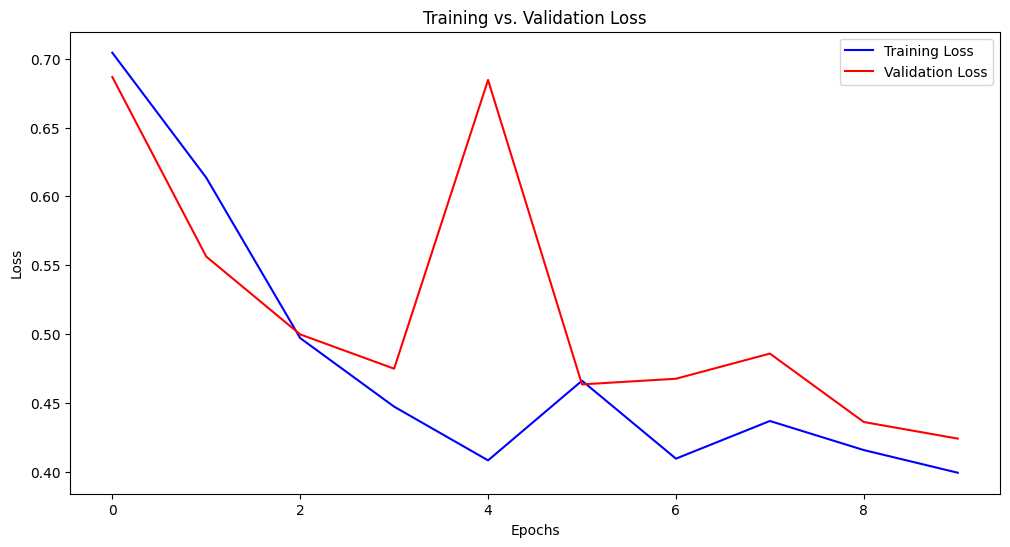

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# Train WBC dataset

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/WBC_100.zip', 'r') as zip_ref:
    wbc_100_unzip_path = '/content/WBC_100'
    zip_ref.extractall(wbc_100_unzip_path)

wbc_100_unzipped_dirs = os.listdir(wbc_100_unzip_path)
wbc_100_unzipped_dirs

['__MACOSX', 'WBC_100']

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/WBC_50.zip', 'r') as zip_ref:
    wbc_50_unzip_path = '/content/WBC_50'
    zip_ref.extractall(wbc_50_unzip_path)

wbc_50_unzipped_dirs = os.listdir(wbc_50_unzip_path)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/WBC_10.zip', 'r') as zip_ref:
    wbc_10_unzip_path = '/content/WBC_10'
    zip_ref.extractall(wbc_10_unzip_path)

wbc_10_unzipped_dirs = os.listdir(wbc_10_unzip_path)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/WBC_1.zip', 'r') as zip_ref:
    wbc_1_unzip_path = '/content/WBC_1'
    zip_ref.extractall(wbc_1_unzip_path)

wbc_1_unzipped_dirs = os.listdir(wbc_1_unzip_path)

In [ ]:
class WBCDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train', subset=False):
        assert mode in ['train', 'val', 'test'], "Mode should be 'train', 'val', or 'test'"

        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.subset = subset

        self.cell_types = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
        self.image_paths = []
        self.labels = []

        if self.subset:
            data_dir = 'data'
        else:
            data_dir = '' if mode == 'val' else 'data'

        for idx, cell_type in enumerate(self.cell_types):
            type_image_paths = glob.glob(os.path.join(root_dir, data_dir, cell_type, '*.jpg'))
            self.image_paths.extend(type_image_paths)
            self.labels.extend([idx] * len(type_image_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [ ]:
wbc_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

wbc_100_train_dataset = WBCDataset(root_dir='/content/WBC_100/WBC_100/train', transform=wbc_transform, mode='train')
wbc_100_val_dataset = WBCDataset(root_dir='/content/WBC_100/WBC_100/val', transform=wbc_transform, mode='val')

print(len(wbc_100_train_dataset))
print(len(wbc_100_val_dataset))

8447
1728


In [ ]:
wbc_50_train_dataset = WBCDataset(root_dir='/content/WBC_50/WBC_50/train', transform=wbc_transform, subset=True)

wbc_10_train_dataset = WBCDataset(root_dir='/content/WBC_10/WBC_10/train', transform=wbc_transform, subset=True)

wbc_1_train_dataset = WBCDataset(root_dir='/content/WBC_1/WBC_1/train', transform=wbc_transform, subset=True)

len(wbc_50_train_dataset), len(wbc_10_train_dataset), len(wbc_1_train_dataset)

(4223, 842, 82)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
simple_cnn = SimpleCNN()

num_epochs = 15
learning_rate = 0.001
batch_size = 32
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loader_100 = torch.utils.data.DataLoader(wbc_100_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_50 = torch.utils.data.DataLoader(wbc_50_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_10 = torch.utils.data.DataLoader(wbc_10_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_1 = torch.utils.data.DataLoader(wbc_1_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_100 = torch.utils.data.DataLoader(wbc_100_val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

datasets = {'WBC_100': train_loader_100, 'WBC_50': train_loader_50, 'WBC_10': train_loader_10, 'WBC_1': train_loader_1}

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, dataset_name):
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        print(f"Training on {dataset_name} - Epoch {epoch+1}/{num_epochs}")
        model.train()

        # Training phase
        train_loss = 0.0
        train_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        print("train_corrects: ", train_corrects)
        train_accuracy = train_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_corrects.double() / len(val_loader.dataset)
        print("val_corrects: ", val_corrects)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}\n")

    # Check if this is the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())

    # Load the best model weights
    model.load_state_dict(best_model)

    return model, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
sequential_weights = autoencoder_weights
sequential_weights.update(camelyon16_weights)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
def map_conv_weights_to_model(model_weights):
    # Mapping only the convolutional layer weights to the SimpleCNN model's naming convention
    mapped_weights = {
        "conv1.weight": model_weights["0.weight"],
        "conv1.bias": model_weights["0.bias"],
        "conv2.weight": model_weights["2.weight"],
        "conv2.bias": model_weights["2.bias"],
        "conv3.weight": model_weights["4.weight"],
        "conv3.bias": model_weights["4.bias"]
    }
    return mapped_weights

In [ ]:
mapped_sequential_weights = map_conv_weights_to_model(sequential_weights)

In [ ]:
results = {}
for dataset_name, train_loader in datasets.items():
    # Model with random weights
    model_random = SimpleCNN().to(device)
    optimizer_random = optim.Adam(model_random.parameters(), lr=learning_rate)
    model_random, train_loss_random, val_loss_random, train_accuracy_random, val_accuracy_random = train_model(
        model_random, train_loader, val_loader_100, criterion, optimizer_random, num_epochs, dataset_name)
    torch.save(model_random.state_dict(), dataset_name+'_random.pth')
    test_accuracy_random = evaluate_model(model_random, val_loader_100)

    # Model with pre-trained weights
    model_pretrained = SimpleCNN().to(device)
    model_pretrained.load_state_dict(mapped_sequential_weights, strict=False)
    optimizer_pretrained = optim.Adam(model_pretrained.parameters(), lr=learning_rate)
    model_pretrained, train_loss_pretrained, val_loss_pretrained, train_accuracy_pretrained, val_accuracy_pretrained = train_model(
        model_pretrained, train_loader, val_loader_100, criterion, optimizer_pretrained, num_epochs, dataset_name)
    torch.save(model_pretrained.state_dict(), dataset_name+'_pretrained.pth')
    test_accuracy_pretrained = evaluate_model(model_pretrained, val_loader_100)

    results[dataset_name] = {
        "Random Weights": {
            "Train Loss": train_loss_random,
            "Val Loss": val_loss_random,
            "Train Accuracy": train_accuracy_random,
            "Val Accuracy": val_accuracy_random,
            "Test Accuracy": test_accuracy_random
        },
        "Pretrained Weights": {
            "Train Loss": train_loss_pretrained,
            "Val Loss": val_loss_pretrained,
            "Train Accuracy": train_accuracy_pretrained,
            "Val Accuracy": val_accuracy_pretrained,
            "Test Accuracy": test_accuracy_pretrained
        }
    }

Training on WBC_100 - Epoch 1/15
train_corrects:  tensor(6805, device='cuda:0')
Train Loss: 0.8303 - Train Accuracy: 0.8056
val_corrects:  tensor(1590, device='cuda:0')
Validation Loss: 0.2459 - Validation Accuracy: 0.9201

Training on WBC_100 - Epoch 2/15
train_corrects:  tensor(7730, device='cuda:0')
Train Loss: 0.2302 - Train Accuracy: 0.9151
val_corrects:  tensor(1612, device='cuda:0')
Validation Loss: 0.2014 - Validation Accuracy: 0.9329

Training on WBC_100 - Epoch 3/15
train_corrects:  tensor(7889, device='cuda:0')
Train Loss: 0.1810 - Train Accuracy: 0.9339
val_corrects:  tensor(1640, device='cuda:0')
Validation Loss: 0.1536 - Validation Accuracy: 0.9491

Training on WBC_100 - Epoch 4/15
train_corrects:  tensor(7983, device='cuda:0')
Train Loss: 0.1499 - Train Accuracy: 0.9451
val_corrects:  tensor(1664, device='cuda:0')
Validation Loss: 0.1264 - Validation Accuracy: 0.9630

Training on WBC_100 - Epoch 5/15
train_corrects:  tensor(8059, device='cuda:0')
Train Loss: 0.1281 - Tra

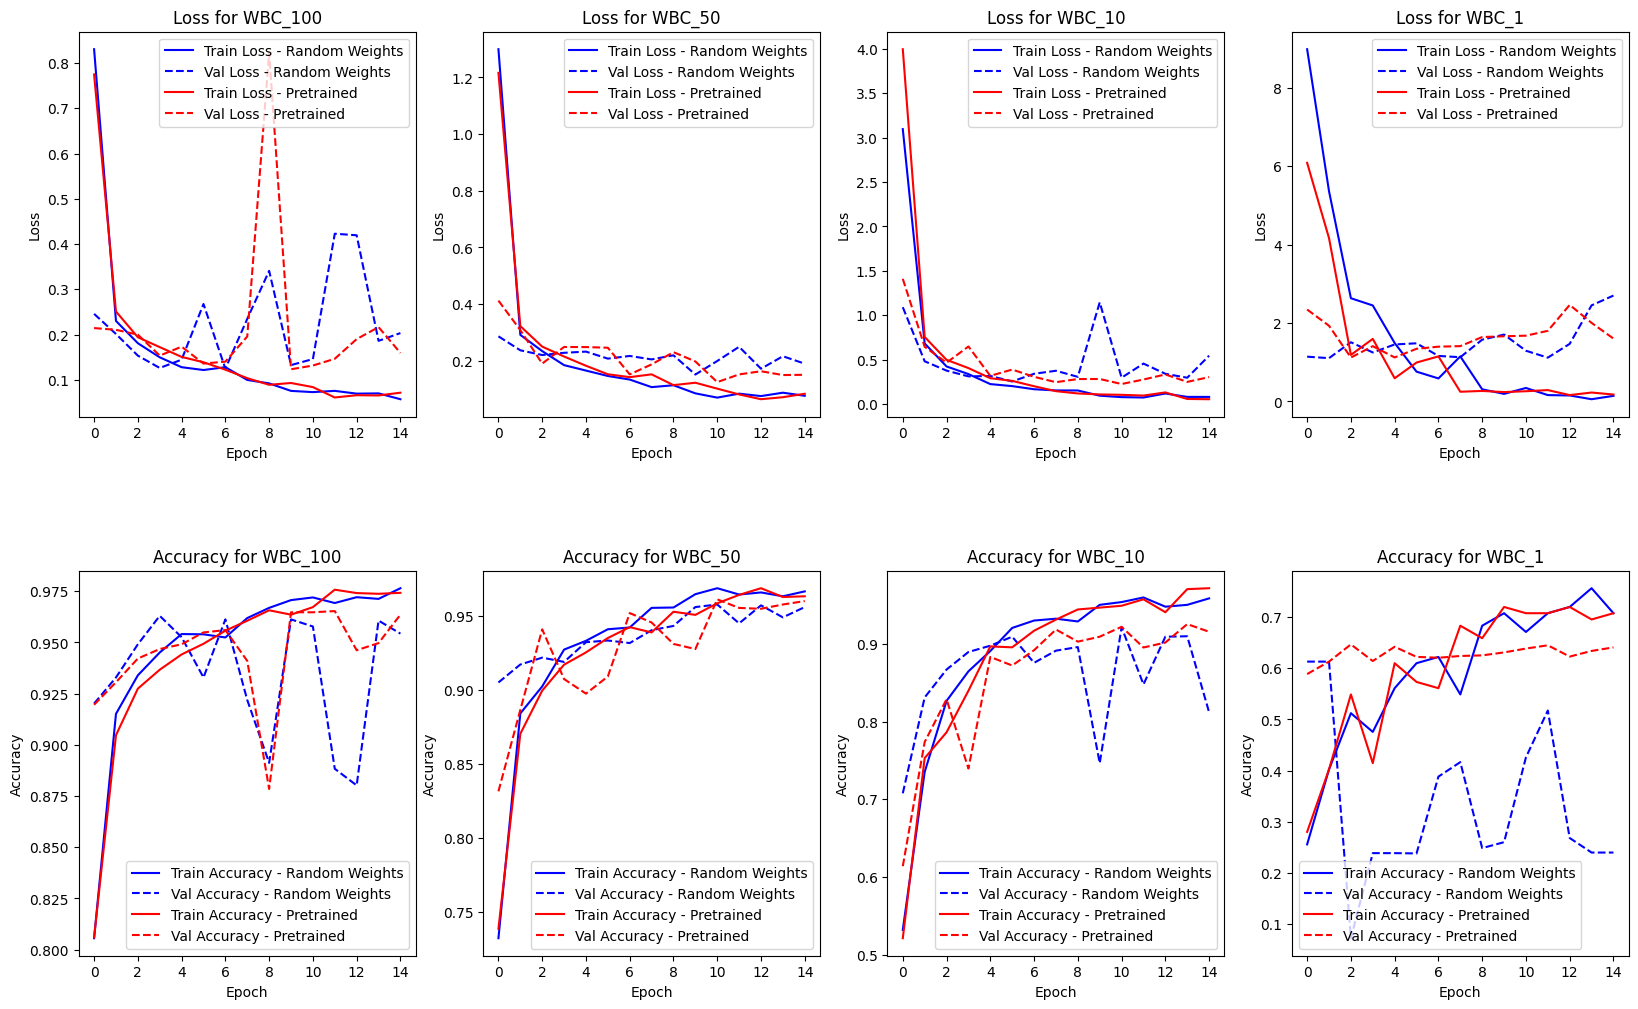

In [ ]:
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# Loop through each dataset to plot the results
for idx, (dataset_name, dataset_results) in enumerate(results.items()):
    # Extract results for random weights and pretrained weights
    random_weights = dataset_results["Random Weights"]
    pretrained_weights = dataset_results["Pretrained Weights"]

    # Plotting Training and Validation Loss
    plt.subplot(2, len(results), idx + 1)
    plt.plot(random_weights["Train Loss"], label="Train Loss - Random Weights", color="blue", linestyle="-")
    plt.plot(random_weights["Val Loss"], label="Val Loss - Random Weights", color="blue", linestyle="--")
    plt.plot(pretrained_weights["Train Loss"], label="Train Loss - Pretrained", color="red", linestyle="-")
    plt.plot(pretrained_weights["Val Loss"], label="Val Loss - Pretrained", color="red", linestyle="--")
    plt.title(f"Loss for {dataset_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(2, len(results), len(results) + idx + 1)
    plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in random_weights["Train Accuracy"]], label="Train Accuracy - Random Weights", color="blue", linestyle="-")
    plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in random_weights["Val Accuracy"]], label="Val Accuracy - Random Weights", color="blue", linestyle="--")
    plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in pretrained_weights["Train Accuracy"]], label="Train Accuracy - Pretrained", color="red", linestyle="-")
    plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in pretrained_weights["Val Accuracy"]], label="Val Accuracy - Pretrained", color="red", linestyle="--")
    plt.title(f"Accuracy for {dataset_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

plt.show()